# Run From Directories Example

In [37]:
from datetime import datetime

import matplotlib.pyplot as plt
import useq
from rich import print

from cali.analysis import AnalysisRunner
from cali.readers import TensorstoreZarrReader
from cali.sqlmodel import (
    AnalysisSettings,
    Experiment,
    print_experiment_tree,
    useq_plate_plan_to_db,
)

In [ ]:
analysis_path = "/Users/fdrgsp/Desktop/cali_test"
data_path = (
    "/Users/fdrgsp/Documents/git/cali/tests/test_data/evoked/evk.tensorstore.zarr"
)
labels_path = "/Users/fdrgsp/Documents/git/cali/tests/test_data/evoked/evk_labels"

exp = Experiment(
    id=0,
    name="New Experiment",
    description="A Test Experiment.",
    created_at=datetime.now(),
    database_name="cali_new.db",
    data_path=data_path,
    labels_path=labels_path,
    analysis_path=analysis_path,
)

In [39]:
# REMOVE
from pathlib import Path

from cali.sqlmodel._json_to_db import load_plate_map


def plate_map() -> dict[str, dict[str, str]]:
    json_path = "/Volumes/T7 Shield/for FG/TSC_hSynLAM77_ACTX250730_D36/TSC_hSynLAM77_ACTX250730_D36_DIV54_250923_jRCaMP1b_Spt_output"
    genotype_map_path = Path(json_path) / "genotype_plate_map.json"
    treatment_map_path = Path(json_path) / "treatment_plate_map.json"

    genotype_map = load_plate_map(genotype_map_path)
    treatment_map = load_plate_map(treatment_map_path)

    plate_maps: dict[str, dict[str, str]] = {}
    if genotype_map:
        plate_maps["genotype"] = {
            well_name: well_data["name"]
            for well_name, well_data in genotype_map.items()
        }
    if treatment_map:
        plate_maps["treatment"] = {
            well_name: well_data["name"]
            for well_name, well_data in treatment_map.items()
        }
    return plate_maps

In [40]:
# load the data and get the useq plate plan from the sequence
data = TensorstoreZarrReader(exp.data_path)
assert data.sequence is not None
plate_plan = data.sequence.stage_positions
assert isinstance(plate_plan, useq.WellPlatePlan)


# Define plate maps for conditions (optional)
# plate_maps = {
#     "genotype": {"B5": "WT"},
#     "treatment": {"B5": "Vehicle"},
# }
plate_maps = plate_map()

# Create plate with plate_maps and conditions in one step
plate = useq_plate_plan_to_db(plate_plan, exp, plate_maps)
exp.plate = plate

print_experiment_tree(exp)

🧪 New Experiment
├── Experiment Type: Spontaneous Activity
├── A Test Experiment.
└── 📋 96-well (96-well)
    ├── 🧫 B2 - 🧪 Conditions: TSC2 +/+
    ├── 🧫 B3 - 🧪 Conditions: TSC2 +/+
    ├── 🧫 D2 - 🧪 Conditions: TSC2 +/-
    ├── 🧫 D3 - 🧪 Conditions: TSC2 +/-
    ├── 🧫 E2 - 🧪 Conditions: TSC2 -/-
    └── 🧫 E3 - 🧪 Conditions: TSC2 -/-

In [41]:
analysis_settings = AnalysisSettings(
    experiment_id=exp.id,
    created_at=datetime.now(),
    threads=5,
    # the rest are defaults
)
exp.analysis_settings = analysis_settings

print_experiment_tree(exp)

🧪 New Experiment
├── Experiment Type: Spontaneous Activity
├── A Test Experiment.
├── ⚙️ Analysis Settings available
└── 📋 96-well (96-well)
    ├── 🧫 B2 - 🧪 Conditions: TSC2 +/+
    ├── 🧫 B3 - 🧪 Conditions: TSC2 +/+
    ├── 🧫 D2 - 🧪 Conditions: TSC2 +/-
    ├── 🧫 D3 - 🧪 Conditions: TSC2 +/-
    ├── 🧫 E2 - 🧪 Conditions: TSC2 -/-
    └── 🧫 E3 - 🧪 Conditions: TSC2 -/-

In [42]:
# specify all positions to be analyzed
exp.positions_analyzed = list(range(len(plate_plan)))
# exp.positions_analyzed = [0, 1]
print(f"Positions to analyze: {exp.positions_analyzed}")

Positions to analyze: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]

In [10]:
analysis = AnalysisRunner()

# Using the Experiment info, this automatically sets the analysis settings (if any) and
# loads the data (if the experiment has a data path).
#
# If you want to only update the analysis settings, you can use:
# runner.update_settings(analysis_settings).
#
# If you want to to only set the data you can use:
# runner.set_data(data) - (where data is a path, a str or cali reader)
analysis.set_experiment(exp)
assert analysis.data() is not None

2025-11-11 13:37:11,723 - cali_logger - INFO - 💾 Experiment analysis updated and saved to database at /Users/fdrgsp/Desktop/cali_test/250923.db.


In [11]:
# run the analysis
analysis.run()

2025-11-11 12:58:29,211 - cali_logger - INFO - Starting Analysis...
2025-11-11 12:58:29,216 - cali_logger - INFO - Starting traces analysis...
2025-11-11 12:58:29,219 - cali_logger - INFO - Number of threads for analysis: 5
2025-11-11 12:58:29,219 - cali_logger - INFO - Positions to analyze: [0]


2025-11-11 12:58:29,272 - cali_logger - INFO - Extracting Traces Data from Well B5_0000_p0.
Extracting Traces Data from Well B5_0000_p0.:   0%|          | 0/4 [00:00<?, ?it/s]/Users/fdrgsp/Documents/git/cali/.venv/lib/python3.12/site-packages/oasis/functions.py:849: UserWarning: nperseg=256 is greater than signal length max(len(x), len(y)) = 153, using nperseg = 153
  ff, Pxx = scipy.signal.welch(y)
/Users/fdrgsp/Documents/git/cali/.venv/lib/python3.12/site-packages/oasis/functions.py:817: FutureWarning: Beginning in SciPy 1.17, multidimensional input will be treated as a batch, not `ravel`ed. To preserve the existing behavior and silence this warning, `ravel` arguments before passing them to `toeplitz`.
  A = scipy.linalg.toeplitz(xc[np.arrange(lags)],
Extracting Traces Data from Well B5_0000_p0.: 100%|██████████| 4/4 [00:00<00:00, 97.08it/s]
2025-11-11 12:58:29,326 - cali_logger - INFO - 💾 Saved analysis data for position 0 to database.
2025-11-11 12:58:29,326 - cali_logger - INFO - 

In [16]:
exp = analysis.experiment()
print_experiment_tree(exp, max_level="fov")

🧪 New Experiment
├── Experiment Type: Spontaneous Activity
├── A Test Experiment.
├── ⚙️ Analysis Settings available
└── 📋 96-well (96-well)
    ├── 🧫 B2 - 🧪 Conditions: TSC2 +/+
    │   ├── 📷 B2_0000_p0 (fov: 0 - pos: 0)
    │   └── 📷 B2_0001_p1 (fov: 1 - pos: 1)
    ├── 🧫 B3 - 🧪 Conditions: TSC2 +/+
    ├── 🧫 D2 - 🧪 Conditions: TSC2 +/-
    ├── 🧫 D3 - 🧪 Conditions: TSC2 +/-
    ├── 🧫 E2 - 🧪 Conditions: TSC2 -/-
    └── 🧫 E3 - 🧪 Conditions: TSC2 -/-

In [17]:
analysis.set_positions_to_analyze([2, 5, 9])

2025-11-11 13:47:45,825 - cali_logger - INFO - ✅ Validated positions [2, 5, 9] (data has 24 positions total)
2025-11-11 13:47:45,830 - cali_logger - INFO - 💾 Positions to analyze updated: [2, 5, 9] in database at /Users/fdrgsp/Desktop/cali_test/250923.db


In [18]:
# run the analysis again on the new positions
analysis.run()

2025-11-11 13:47:54,600 - cali_logger - INFO - Starting Analysis...
2025-11-11 13:47:55,126 - cali_logger - INFO - Starting traces analysis...
2025-11-11 13:47:55,629 - cali_logger - INFO - Number of threads for analysis: 5
2025-11-11 13:47:55,630 - cali_logger - INFO - Positions to analyze: [2, 5, 9]
2025-11-11 13:48:03,757 - cali_logger - INFO - Extracting Traces Data from Well B2_0002_p2.
Extracting Traces Data from Well B2_0002_p2.:   0%|          | 0/118 [00:00<?, ?it/s]/Users/fdrgsp/Documents/git/cali/.venv/lib/python3.12/site-packages/oasis/functions.py:817: FutureWarning: Beginning in SciPy 1.17, multidimensional input will be treated as a batch, not `ravel`ed. To preserve the existing behavior and silence this warning, `ravel` arguments before passing them to `toeplitz`.
  A = scipy.linalg.toeplitz(xc[np.arrange(lags)],
Extracting Traces Data from Well B2_0002_p2.:  53%|█████▎    | 62/118 [00:13<00:30,  1.85it/s]2025-11-11 13:48:17,579 - cali_logger - INFO - Extracting Traces 

In [20]:
exp = analysis.experiment()
print_experiment_tree(exp, max_level="fov")

🧪 New Experiment
├── Experiment Type: Spontaneous Activity
├── A Test Experiment.
├── ⚙️ Analysis Settings available
└── 📋 96-well (96-well)
    ├── 🧫 B2 - 🧪 Conditions: TSC2 +/+
    │   ├── 📷 B2_0000_p0 (fov: 0 - pos: 0)
    │   ├── 📷 B2_0001_p1 (fov: 1 - pos: 1)
    │   └── 📷 B2_0002_p2 (fov: 2 - pos: 2)
    ├── 🧫 B3 - 🧪 Conditions: TSC2 +/+
    │   └── 📷 B3_0001_p5 (fov: 5 - pos: 5)
    ├── 🧫 D2 - 🧪 Conditions: TSC2 +/-
    │   └── 📷 D2_0001_p9 (fov: 9 - pos: 9)
    ├── 🧫 D3 - 🧪 Conditions: TSC2 +/-
    ├── 🧫 E2 - 🧪 Conditions: TSC2 -/-
    └── 🧫 E3 - 🧪 Conditions: TSC2 -/-

In [21]:
# Create new analysis settings with different parameters
analysis_settings_new = AnalysisSettings(
    experiment_id=exp.id,
    created_at=datetime.now(),
    threads=10,
    dff_window=50,
    # the rest are defaults
)

# Update the analysis settings
analysis.update_settings(analysis_settings_new)

2025-11-11 13:49:47,171 - cali_logger - INFO - 💾 Analysis settings updated in database at /Users/fdrgsp/Desktop/cali_test/250923.db


In [22]:
# specify new positions to be analyzed
analysis.set_positions_to_analyze([3])

2025-11-11 13:50:18,105 - cali_logger - INFO - ✅ Validated positions [3] (data has 24 positions total)
2025-11-11 13:50:18,108 - cali_logger - INFO - 💾 Positions to analyze updated: [3] in database at /Users/fdrgsp/Desktop/cali_test/250923.db


In [35]:
# Clear previous analysis results. This is optional but recommended to avoid
# to have different positions analyzed with different settings.
analysis.clear_analysis_results()
# run the analysis
analysis.run()

2025-11-11 13:04:16,348 - cali_logger - INFO - Deleting 4 ROIs and their associated data...
2025-11-11 13:04:16,357 - cali_logger - INFO - 💾 Analysis results cleared from database.
2025-11-11 13:04:16,358 - cali_logger - INFO - Starting Analysis...
2025-11-11 13:04:16,360 - cali_logger - INFO - Starting traces analysis...
2025-11-11 13:04:16,363 - cali_logger - INFO - Number of threads for analysis: 10
2025-11-11 13:04:16,363 - cali_logger - INFO - Positions to analyze: [0]
2025-11-11 13:04:16,401 - cali_logger - INFO - Extracting Traces Data from Well B5_0000_p0.
Extracting Traces Data from Well B5_0000_p0.:   0%|          | 0/4 [00:00<?, ?it/s]/Users/fdrgsp/Documents/git/cali/.venv/lib/python3.12/site-packages/oasis/functions.py:849: UserWarning: nperseg=256 is greater than signal length max(len(x), len(y)) = 153, using nperseg = 153
  ff, Pxx = scipy.signal.welch(y)
/Users/fdrgsp/Documents/git/cali/.venv/lib/python3.12/site-packages/oasis/functions.py:817: FutureWarning: Beginning i

In [36]:
# get the updated experiment with analysis results
exp = analysis.experiment()
print_experiment_tree(exp, max_level="fov")

🧪 New Experiment
├── Experiment Type: Spontaneous Activity
├── A Test Experiment.
├── ⚙️ Analysis Settings available
└── 📋 96-well (96-well)
    ├── 🧫 B2 - 🧪 Conditions: TSC2 +/+
    │   └── 📷 B2_0003_p3 (fov: 3 - pos: 3)
    ├── 🧫 B3 - 🧪 Conditions: TSC2 +/+
    ├── 🧫 D2 - 🧪 Conditions: TSC2 +/-
    ├── 🧫 D3 - 🧪 Conditions: TSC2 +/-
    ├── 🧫 E2 - 🧪 Conditions: TSC2 -/-
    └── 🧫 E3 - 🧪 Conditions: TSC2 -/-

In [9]:
from sqlmodel import select

statement = select(Experiment.plate.wells[0].fovs)
print(statement)


# fov in exp.plate.wells[0].fovs:
#     for roi in fov.rois:
#         plt.plot(roi.traces.dec_dff)
# plt.show()

AttributeError: Neither 'InstrumentedAttribute' object nor 'Comparator' object associated with Experiment.plate has an attribute 'wells'

In [ ]:
# since we want to run a new analysis with different settings, we should
# clear previous analysis results before running the new analysis
exp = analysis.clear_analysis_results()

# update the analysis settings with a new dff_window for example
analysis.update_settings(analysis_settings1)
print_experiment_tree(exp)

🧪 New Experiment
├── Experiment Type: Spontaneous Activity
├── A Test Experiment.
├── ⚙️ Analysis Settings available
└── 📋 96-well (96-well)
    └── 🧫 B5 - 🧪 Conditions: WT, Vehicle
        └── 📷 B5_0000_p0 (fov: 0 - pos: 0)

In [66]:
# run the analysis with the new settings
analysis.run()

# get the updated experiment with analysis results
exp = analysis.experiment()

2025-11-11 02:23:26,376 - cali_logger - INFO - Starting Analysis...
2025-11-11 02:23:26,377 - cali_logger - INFO - Starting traces analysis...
2025-11-11 02:23:26,377 - cali_logger - INFO - Number of threads for analysis: 5
2025-11-11 02:23:26,377 - cali_logger - INFO - Positions to analyze: [0]
2025-11-11 02:23:26,406 - cali_logger - INFO - Extracting Traces Data from Well B5_0000_p0.
Extracting Traces Data from Well B5_0000_p0.:   0%|          | 0/4 [00:00<?, ?it/s]/Users/fdrgsp/Documents/git/cali/.venv/lib/python3.12/site-packages/oasis/functions.py:849: UserWarning: nperseg=256 is greater than signal length max(len(x), len(y)) = 153, using nperseg = 153
  ff, Pxx = scipy.signal.welch(y)
/Users/fdrgsp/Documents/git/cali/.venv/lib/python3.12/site-packages/oasis/functions.py:817: FutureWarning: Beginning in SciPy 1.17, multidimensional input will be treated as a batch, not `ravel`ed. To preserve the existing behavior and silence this warning, `ravel` arguments before passing them to `

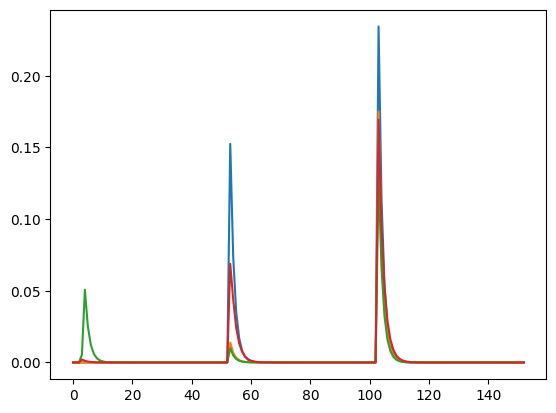

In [48]:
for fov in exp.plate.wells[0].fovs:
    for roi in fov.rois:
        plt.plot(roi.traces.dec_dff)
plt.show()

## ⚠️ IMPORTANT: Refactoring in Progress

**AnalysisRunner is being refactored to follow SQLModel best practices:**

### What Changed

1. **Store engine + ID instead of full experiment object**
   ```python
   # Before:
   self._experiment: Experiment | None = None
   
   # After:
   self._engine: Engine | None = None
   self._experiment_id: int | None = None
   ```

2. **Use context managers for all database operations**
   ```python
   # Now all methods use:
   with Session(self._engine) as session:
       # ... database operations
       session.commit()
   ```

3. **Explicit `session.delete()` instead of just clearing lists**
   ```python
   # Before:
   fov.rois.clear()  # Just clear Python list
   save_experiment_to_database(exp)  # Hope cascade works
   
   # After:
   for roi in rois:
       session.delete(roi)  # Explicit deletion
   session.commit()  # Explicit commit
   ```

### Key Method Changes

- **`experiment()`**: Now loads from DB on-demand instead of returning cached object
- **`clear_analysis_results()`**: Returns `None` now (doesn't return experiment)
- **`update_settings()`**: Uses proper session management with explicit deletion

### Benefits

✅ Lower memory usage (don't keep entire object graph in memory)  
✅ Follows SQLModel docs patterns exactly  
✅ No more `DetachedInstanceError`  
✅ Clearer transaction boundaries  
✅ Explicit deletion as per https://sqlmodel.tiangolo.com/tutorial/delete/

### Migration Guide for This Notebook

```python
# Before:
exp = analysis.clear_analysis_results()  # Returned experiment
print_experiment_tree(exp)

# After:
analysis.clear_analysis_results()  # Returns None now
exp = analysis.experiment()  # Load fresh from DB when needed
print_experiment_tree(exp)
```